In [5]:
%load_ext autoreload
%autoreload 2

from data.dataloader import DataLoader

In [6]:
!pwd

/Users/wongpuihang/Desktop/NLP Assignment 2/NLP_A2_2025


In [7]:
import pandas as pd
data = pd.read_csv('data/dataset.csv')

In [18]:
from data.dataloader import text_clean
import spacy
import warnings
warnings.filterwarnings("ignore")

# preprocess title column
nlp = spacy.load("en_core_web_sm")

data['cleaned_title'] = data['title'].apply(
            lambda x: text_clean(x, nlp)
        )

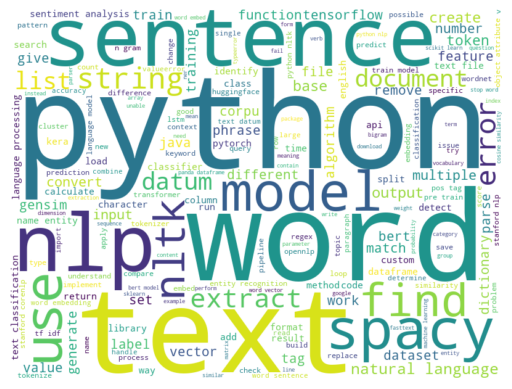

In [21]:
# generate wordcloud for the title in posts

from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(word for word in data['cleaned_title'])
wordc = WordCloud(width = 800, height = 600, background_color='white').generate(text)
plt.figure()
plt.imshow(wordc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.85)
tfidf = vectorizer.fit_transform(data['cleaned_title'])

feature_names = vectorizer.get_feature_names_out()
idf_scores = vectorizer.idf_

# create a dictionary mapping each term to its IDF score.
idf_dict = dict(zip(feature_names, idf_scores))

# sort the terms based on the IDF scores (lowest first).
sorted_terms = sorted(idf_dict.items(), key=lambda item: item[1])
#print(sorted_terms)

# create custom stop words list to add those terms with low IDF score (threshold < 4)
custom_stop_words = []
for term, score in sorted_terms:
    if score <= 4:
        custom_stop_words.append(term)

# again perform stop word removal
def custom_stop_word_removal(text):
    tokens = word_tokenize(text)
    text = [word for word in tokens if word.lower() not in custom_stop_words]
    text = " ".join(text)
    return text

data['cleaned_title'] = data['cleaned_title'].apply(custom_stop_word_removal)

In [ ]:
updated_text = " ".join(word for word in data_1['cleaned_title_x'])
updated_wordc = WordCloud(width = 800, height = 600, background_color='white').generate(updated_text)
plt.figure()
plt.imshow(updated_wordc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
# unsupervised topic modelling - LDA

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

LDA_vectorizer = CountVectorizer(max_df=0.85)
LDA_tfidf = LDA_vectorizer.fit_transform(data['cleaned_text'])

lda = LatentDirichletAllocation(n_components=15)
lda.fit(LDA_tfidf)

feature_names = LDA_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-5:]]
    print(f"Topic {topic_idx}: {' '.join(top_words)}")

Topic 0: model ner name spacy entity
Topic 1: run code try file error
Topic 2: sentence similarity find document word
Topic 3: datum answer query user question
Topic 4: email text product search cluster
Topic 5: nltk language word pos tag
Topic 6: algorithm language function probability token
Topic 7: try like list text word
Topic 8: nlp tweet machine category text
Topic 9: string row dataframe list column
Topic 10: example noun parse like sentence
Topic 11: dataset datum training train model
Topic 12: nlp like language extract text
Topic 13: review positive negative analysis sentiment
Topic 14: layer input word embed vector


In [23]:
# K-means clustering with tf-idf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

k_vectorizer = TfidfVectorizer(max_df=0.85)
k_tfidf = k_vectorizer.fit_transform(data['cleaned_text'])

# Set number of clusters (e.g., 5) and perform k-means clustering.
kmeans = KMeans(n_clusters=10)
kmeans.fit(k_tfidf)


# Extract cluster centers and find the top terms in each cluster.
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = k_vectorizer.get_feature_names_out()

for i in range(10):
    top_terms = [terms[ind] for ind in order_centroids[i, :5]]
    print(f"Cluster {i}: {' '.join(top_terms)}")

Cluster 0: document similarity term topic word idf tf matrix text corpus
Cluster 1: tag pos tagger word nltk sentence tagging stanford speech noun
Cluster 2: text like file want use try code extract python output
Cluster 3: word list text like want find string python remove code
Cluster 4: sentence word like text list want example parse find try
Cluster 5: model train training datum bert dataset use try text load
Cluster 6: error try code get run follow import file model python
Cluster 7: language natural processing english text nlp use library work python
Cluster 8: column dataframe row panda text word datum string like list
Cluster 9: vector word embed embedding model layer train glove sentence dimension


In [32]:
# !pip install bertopic
# !pip install tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.9 MB/s eta 0:00:00a 0:00:01


In [36]:
# topic Labelling - BERTopic

from bertopic import BERTopic
import tf_keras as keras

topic_model = BERTopic(nr_topics=10)
topics, probs = topic_model.fit_transform(data['cleaned_text'])

topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,9734,-1_word_text_model_sentence,"[word, text, model, sentence, like, try, use, ...",[simple way tell spacy ignore stop word method...
1,0,5090,0_word_text_like_sentence,"[word, text, like, sentence, use, try, want, c...",[extract phrase text specific noun verb noun n...
2,1,1803,1_model_train_bert_embed,"[model, train, bert, embed, word, layer, vecto...",[keras valueerror error check target expect di...
3,2,1327,2_similarity_word_column_dataframe,"[similarity, word, column, dataframe, cosine, ...",[find similar string value dataframe find simi...
4,3,907,3_error_try_model_code,"[error, try, model, code, run, import, python,...",[nltk give error try use nltk nlp learning pyt...
5,4,893,4_file_text_list_pdf,"[file, text, list, pdf, word, extract, python,...",[difference string read text file string varia...
6,5,107,5_lucene_elasticsearch_search_query,"[lucene, elasticsearch, search, query, index, ...",[approach suggestiosn classify keyword search ...
7,6,75,6_api_google_cloud_error,"[api, google, cloud, error, openai, language, ...",[request insufficient authentication scope mak...
8,7,40,7_countvectorizer_sklearn_word_count,"[countvectorizer, sklearn, word, count, scikit...",[control way countvectorizer vectorize corpus ...
9,8,24,8_imbalance_smote_class_dataset,"[imbalance, smote, class, dataset, oversample,...",[remove minority class certain number example ...


In [39]:
topic_model.get_topic_info(0)

,Topic,Count,Name,Representation,Representative_Docs
0,0,5090,0_word_text_like_sentence,"[word, text, like, sentence, use, try, want, c...",[extract phrase text specific noun verb noun n...
